In [3]:
import sys
sys.path.append('../../Models')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

from RealNVP import *
from sklearn import datasets

In [4]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# Only run once, then load saved model
# flow = train(datasets, max_epochs=10000)

In [12]:
# Load flow
path_model = "TrainedModels/flow.pth"
flow = RealNVP(tfm_layers=6, latent_dim=2, device="cpu").to("cpu")
flow.load_state_dict(torch.load(path_model))
flow.eval()

RealNVP(
  (block_scale): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Tanh()
  )
  (block_trans): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (net_trans): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_f

Text(0.5, 1.0, '$X = g(z)$')

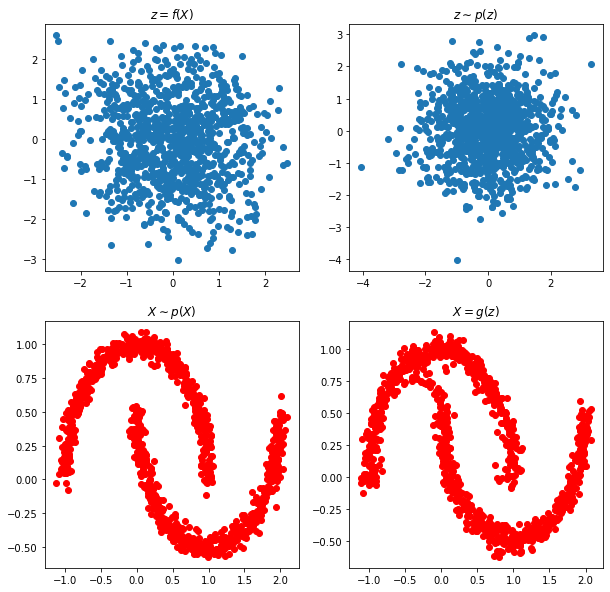

In [13]:
fig = plt.figure()
fig.patch.set_facecolor('w')

noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.to_latent(torch.from_numpy(noisy_moons))[0].detach().numpy()

plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

plt.savefig("sanity_check", transparent=False)

## Getting the latent interpolation

In [14]:
cmap = matplotlib.cm.get_cmap('viridis')

Text(0.5, 1.0, '$z = f(X)$')

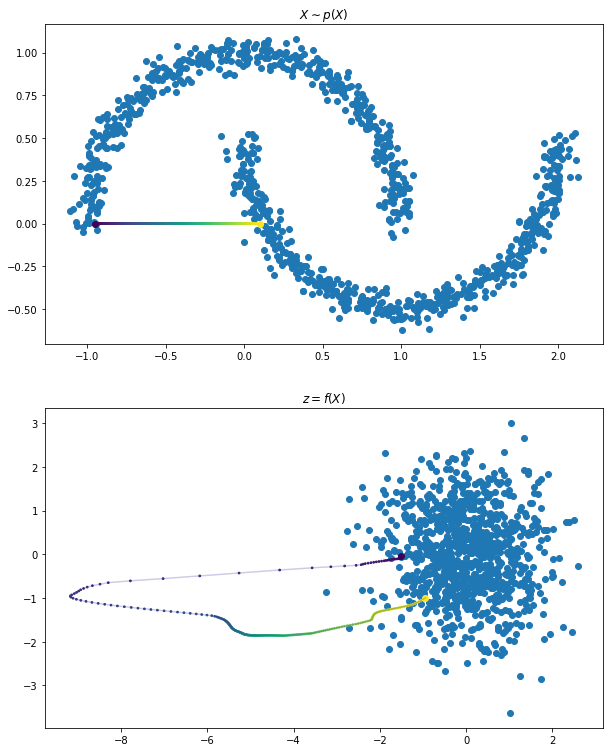

In [15]:
plt.close()

fig = plt.figure(figsize=(10, 20))
fig.patch.set_facecolor('w')
plt.subplot(223)

# Image space
x = datasets.make_moons(n_samples=1000, noise=.05, random_state=42)[0].astype(np.float32)
plt.subplot(311)
plt.scatter(x[:, 0], x[:, 1])

pts = np.linspace([-0.95, -0], [0.1, -0.0], 250, dtype=np.float32)
plt.scatter(pts[:, 0], pts[:, 1], c=range(len(pts)), cmap=cmap, s=3)
plt.scatter(pts[0, 0], pts[0, 1], c=1, cmap=cmap)
plt.scatter(pts[-1, 0], pts[-1, 1], c=[cmap(1.)])
plt.title(r'$X \sim p(X)$')


# Latent space
z = flow.to_latent(torch.from_numpy(x))[0].detach().numpy()
plt.subplot(312)
plt.scatter(z[:, 0], z[:, 1])

z_pts = flow.to_latent(torch.from_numpy(pts))[0].detach().numpy()
plt.plot(z_pts[:, 0], z_pts[:, 1], c=[0, 0, 0.5, 0.2])
plt.scatter(z_pts[:, 0], z_pts[:, 1], c=range(len(pts)), cmap=cmap, s=3)
plt.scatter(z_pts[0, 0], z_pts[0, 1], c=1, cmap=cmap)
plt.scatter(z_pts[-1, 0], z_pts[-1, 1], c=[cmap(1.)])
plt.title(r'$z = f(X)$')

Text(0.5, 1.0, '$z = f(X)$')

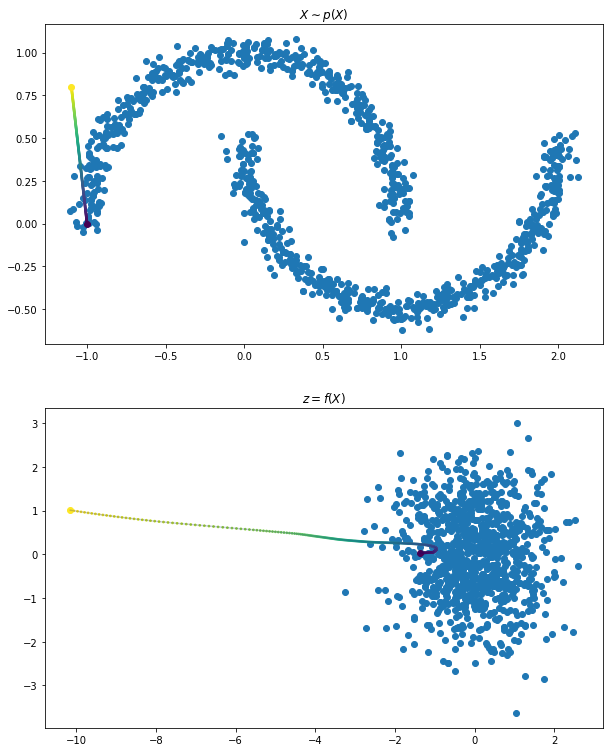

In [16]:
plt.close()

fig = plt.figure(figsize=(10, 20))
fig.patch.set_facecolor('w')
plt.subplot(223)

# Image space
x = datasets.make_moons(n_samples=1000, noise=.05, random_state=42)[0].astype(np.float32)
plt.subplot(311)
plt.scatter(x[:, 0], x[:, 1])

pts = np.linspace([-1.0, -0], [-1.1, 0.8], 250, dtype=np.float32)
plt.scatter(pts[:, 0], pts[:, 1], c=range(len(pts)), cmap=cmap, s=3)
plt.scatter(pts[0, 0], pts[0, 1], c=1, cmap=cmap)
plt.scatter(pts[-1, 0], pts[-1, 1], c=[cmap(1.)])
plt.title(r'$X \sim p(X)$')


# Latent space
z = flow.to_latent(torch.from_numpy(x))[0].detach().numpy()
plt.subplot(312)
plt.scatter(z[:, 0], z[:, 1])

z_pts = flow.to_latent(torch.from_numpy(pts))[0].detach().numpy()
plt.plot(z_pts[:, 0], z_pts[:, 1], c=[0, 0, 0.5, 0.2])
plt.scatter(z_pts[:, 0], z_pts[:, 1], c=range(len(pts)), cmap=cmap, s=3)
plt.scatter(z_pts[0, 0], z_pts[0, 1], c=1, cmap=cmap)
plt.scatter(z_pts[-1, 0], z_pts[-1, 1], c=[cmap(1.)])
plt.title(r'$z = f(X)$')

Text(0.5, 1.0, '$z = f(X)$')

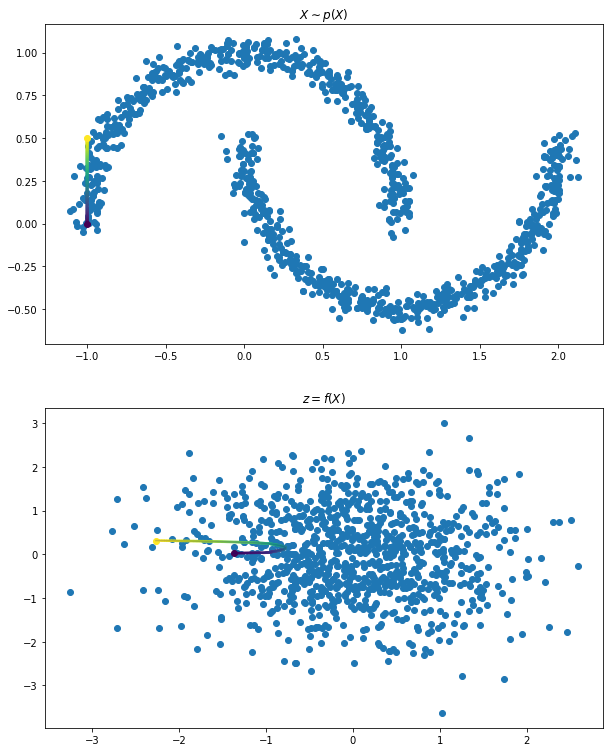

In [17]:
plt.close()

fig = plt.figure(figsize=(10, 20))
fig.patch.set_facecolor('w')

# Image space
x = datasets.make_moons(n_samples=1000, noise=.05, random_state=42)[0].astype(np.float32)
plt.subplot(311)
plt.scatter(x[:, 0], x[:, 1])

pts = np.linspace([-1.0, -0], [-1.0, 0.5], 250, dtype=np.float32)
plt.scatter(pts[:, 0], pts[:, 1], c=range(len(pts)), cmap=cmap, s=3)
plt.scatter(pts[0, 0], pts[0, 1], c=1, cmap=cmap)
plt.scatter(pts[-1, 0], pts[-1, 1], c=[cmap(1.)])
plt.title(r'$X \sim p(X)$')


# Latent space
z = flow.to_latent(torch.from_numpy(x))[0].detach().numpy()
plt.subplot(312)
plt.scatter(z[:, 0], z[:, 1])

z_pts = flow.to_latent(torch.from_numpy(pts))[0].detach().numpy()
plt.plot(z_pts[:, 0], z_pts[:, 1], c=[0, 0, 0.5, 0.2])
plt.scatter(z_pts[:, 0], z_pts[:, 1], c=range(len(pts)), cmap=cmap, s=3)
plt.scatter(z_pts[0, 0], z_pts[0, 1], c=1, cmap=cmap)
plt.scatter(z_pts[-1, 0], z_pts[-1, 1], c=[cmap(1.)])
plt.title(r'$z = f(X)$')

Text(0.5, 1.0, '$z = f(X)$')

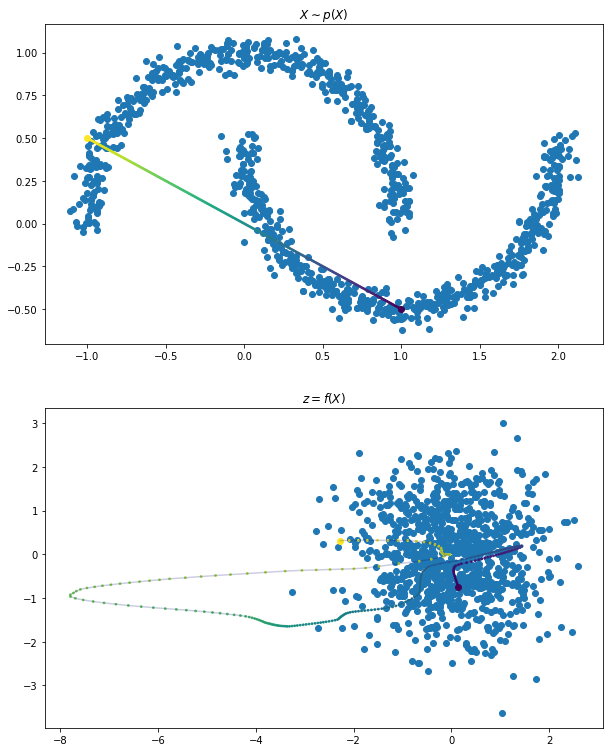

In [18]:
plt.close()

fig = plt.figure(figsize=(10, 20))
fig.patch.set_facecolor('w')

# Image space
x = datasets.make_moons(n_samples=1000, noise=.05, random_state=42)[0].astype(np.float32)
plt.subplot(311)
plt.scatter(x[:, 0], x[:, 1])

pts = np.linspace([1.0, -0.5], [-1.0, 0.5], 250, dtype=np.float32)
plt.scatter(pts[:, 0], pts[:, 1], c=range(len(pts)), cmap=cmap, s=3)
plt.scatter(pts[0, 0], pts[0, 1], c=1, cmap=cmap)
plt.scatter(pts[-1, 0], pts[-1, 1], c=[cmap(1.)])
plt.title(r'$X \sim p(X)$')


# Latent space
z = flow.to_latent(torch.from_numpy(x))[0].detach().numpy()
plt.subplot(312)
plt.scatter(z[:, 0], z[:, 1])

z_pts = flow.to_latent(torch.from_numpy(pts))[0].detach().numpy()
plt.plot(z_pts[:, 0], z_pts[:, 1], c=[0, 0, 0.5, 0.2])
plt.scatter(z_pts[:, 0], z_pts[:, 1], c=range(len(pts)), cmap=cmap, s=3)
plt.scatter(z_pts[0, 0], z_pts[0, 1], c=1, cmap=cmap)
plt.scatter(z_pts[-1, 0], z_pts[-1, 1], c=[cmap(1.)])
plt.title(r'$z = f(X)$')

## Scratch

In [6]:
from torch.autograd.functional import jacobian
from torch.autograd import grad
import torch

In [20]:
def exp_adder(x):
    return 2 * x[0] + y

inputs = torch.rand(6)
print(inputs)
j = jacobian(exp_adder, inputs, vectorize=True)
# g = grad(exp_adder(), inputs)
print(j)

tensor([0.2900, 0.6544, 0.7477, 0.0223, 0.8504, 0.9659])


NameError: name 'y' is not defined